In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, precision_score, recall_score

In [2]:
notebook_name = '5_classes_EfficientNetV2B1_96x96_bs_256_weighted'

In [3]:
train_dir = '../data/images/train'
val_dir = '../data/images/val'
test_dir = '../data/images/test'

train_df = pd.read_csv('../data/majority_train.csv')
val_df = pd.read_csv('../data/majority_val.csv')
test_df = pd.read_csv('../data/majority_test.csv')

In [4]:
train_df = train_df[(train_df['class'] != 'contempt') & (train_df['class'] != 'disgust') & (train_df['class'] != 'fear')]
val_df = val_df[(val_df['class'] != 'contempt') & (val_df['class'] != 'disgust') & (val_df['class'] != 'fear')]
test_df = test_df[(test_df['class'] != 'contempt') & (test_df['class'] != 'disgust') & (test_df['class'] != 'fear')]

In [5]:
train_df

,filename,class
0,fer0000001.png,neutral
1,fer0000002.png,neutral
2,fer0000004.png,neutral
3,fer0000005.png,neutral
4,fer0000006.png,sadness
...,...,...
25039,fer0028632.png,surprise
25041,fer0028634.png,anger
25042,fer0028635.png,sadness
25043,fer0028636.png,neutral


In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.05,
    shear_range=np.rad2deg(np.arctan(0.05)),
    horizontal_flip=True,
    fill_mode='reflect',
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

target_size = (96, 96)
interpolation = 'bilinear'
color_mode = 'grayscale'
batch_size = 256

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    target_size=target_size,
    interpolation=interpolation,
    color_mode=color_mode,
    batch_size=batch_size,
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=val_dir,
    target_size=target_size,
    interpolation=interpolation,
    color_mode=color_mode,
    batch_size=batch_size,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    target_size=target_size,
    interpolation=interpolation,
    color_mode=color_mode,
    batch_size=batch_size,
)

Found 24273 validated image filenames belonging to 5 classes.
Found 3090 validated image filenames belonging to 5 classes.
Found 3020 validated image filenames belonging to 5 classes.


In [7]:
labels = list(train_generator.class_indices.keys())

In [8]:
labels

['anger', 'happiness', 'neutral', 'sadness', 'surprise']

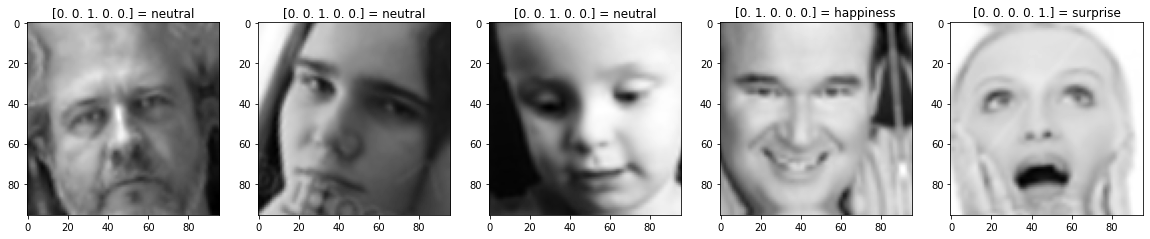

In [9]:
data = next(train_generator)

plt.figure(figsize=[20, 20])

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(f'{data[1][i]} = {labels[np.argmax(data[1][i])]}')
    plt.imshow(data[0][i], cmap='gray')

plt.show()

In [10]:
model = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
    input_shape=(96, 96, 1),
    weights=None,
    classes=5,
)

In [11]:
model.summary()

Model: "efficientnetv2-b1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 96, 96, 1)    0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 48, 48, 32)   288         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 48, 48, 32)   128         ['stem_conv[0][0]']              
                                                                                  

 block3a_expand_conv (Conv2D)   (None, 12, 12, 128)  36864       ['block2c_add[0][0]']            
                                                                                                  
 block3a_expand_bn (BatchNormal  (None, 12, 12, 128)  512        ['block3a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3a_expand_activation (Act  (None, 12, 12, 128)  0          ['block3a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3a_project_conv (Conv2D)  (None, 12, 12, 48)   6144        ['block3a_expand_activation[0][0]
                                                                 ']                               
          

                                                                                                  
 block4b_expand_bn (BatchNormal  (None, 6, 6, 384)   1536        ['block4b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4b_expand_activation (Act  (None, 6, 6, 384)   0           ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv2 (DepthwiseConv  (None, 6, 6, 384)   3456        ['block4b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4b_b

                                                                                                  
 block4d_bn (BatchNormalization  (None, 6, 6, 384)   1536        ['block4d_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4d_activation (Activation  (None, 6, 6, 384)   0           ['block4d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4d_se_squeeze (GlobalAver  (None, 384)         0           ['block4d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4d_s

 block5b_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_se_excite (Multiply)   (None, 6, 6, 672)    0           ['block5b_activation[0][0]',     
                                                                  'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, 6, 6, 112)    75264       ['block5b_se_excite[0][0]']      
                                                                                                  
 block5b_project_bn (BatchNorma  (None, 6, 6, 112)   448         ['block5b_project_conv[0][0]']   
 lization)

 block5d_project_bn (BatchNorma  (None, 6, 6, 112)   448         ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_add (Add)              (None, 6, 6, 112)    0           ['block5d_project_bn[0][0]',     
                                                                  'block5c_add[0][0]']            
                                                                                                  
 block5e_expand_conv (Conv2D)   (None, 6, 6, 672)    75264       ['block5d_add[0][0]']            
                                                                                                  
 block5e_expand_bn (BatchNormal  (None, 6, 6, 672)   2688        ['block5e_expand_conv[0][0]']    
 ization)                                                                                         
          

 ization)                                                                                         
                                                                                                  
 block6a_expand_activation (Act  (None, 6, 6, 672)   0           ['block6a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6a_dwconv2 (DepthwiseConv  (None, 3, 3, 672)   6048        ['block6a_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6a_bn (BatchNormalization  (None, 3, 3, 672)   2688        ['block6a_dwconv2[0][0]']        
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 block6c_se_squeeze (GlobalAver  (None, 1152)        0           ['block6c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6c_se_reshape[0][0]']     
                                                                                                  
 block6c_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6c_se_reduce[0][0]']      
          

 block6e_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6e_se_reduce[0][0]']      
                                                                                                  
 block6e_se_excite (Multiply)   (None, 3, 3, 1152)   0           ['block6e_activation[0][0]',     
                                                                  'block6e_se_expand[0][0]']      
                                                                                                  
 block6e_project_conv (Conv2D)  (None, 3, 3, 192)    221184      ['block6e_se_excite[0][0]']      
                                                                                                  
 block6e_project_bn (BatchNorma  (None, 3, 3, 192)   768         ['block6e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6e_a

                                                                                                  
 block6g_add (Add)              (None, 3, 3, 192)    0           ['block6g_project_bn[0][0]',     
                                                                  'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 3, 3, 1152)   221184      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 3, 3, 1152)  4608        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 3, 3, 1152)  0           ['block6h_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 avg_pool (GlobalAveragePooling  (None, 1280)        0           ['top_activation[0][0]']         
 2D)                                                                                              
                                                                                                  
 top_dropout (Dropout)          (None, 1280)         0           ['avg_pool[0][0]']               
                                                                                                  
 predictions (Dense)            (None, 5)            6405        ['top_dropout[0][0]']            
                                                                                                  
Total params: 6,936,953
Trainable params: 6,865,881
Non-trainable params: 71,072
__________________________________________________________________________________________________


In [12]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
  )

In [13]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.1,
    patience=10,
    verbose=2,
)

In [14]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=20,
    restore_best_weights=True,
    verbose=2,
)

In [15]:
min_loss_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/min_loss.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=2,
)

In [16]:
max_accuracy_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/max_accuracy.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=2,
)

In [17]:
max_precision_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/max_precision.h5',
    monitor='val_precision',
    mode='max',
    save_best_only=True,
    verbose=2,
)

In [18]:
max_recall_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/max_recall.h5',
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    verbose=2,
)

In [19]:
labels

['anger', 'happiness', 'neutral', 'sadness', 'surprise']

In [20]:
class_weights = {
    0: 1.0,
    1: 1.0,
    2: 0.6,
    3: 1.0,
    4: 1.0,
}

In [21]:
fit_history = model.fit(
    train_generator,
    epochs=300,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[
        lr_callback,
        early_stop_callback,
        min_loss_callback,
        max_accuracy_callback,
        max_precision_callback,
        max_recall_callback,
    ],
    verbose=2,
)

Epoch 1/300

Epoch 1: val_loss improved from inf to 2.01921, saving model to ../models/EfficientNetV2B1_96x96_256_5_classes_weighted_manually_2\min_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.37735, saving model to ../models/EfficientNetV2B1_96x96_256_5_classes_weighted_manually_2\max_accuracy.h5

Epoch 1: val_precision improved from -inf to 0.40373, saving model to ../models/EfficientNetV2B1_96x96_256_5_classes_weighted_manually_2\max_precision.h5

Epoch 1: val_recall improved from -inf to 0.33657, saving model to ../models/EfficientNetV2B1_96x96_256_5_classes_weighted_manually_2\max_recall.h5
95/95 - 64s - loss: 2.9798 - accuracy: 0.2736 - precision: 0.2884 - recall: 0.1961 - val_loss: 2.0192 - val_accuracy: 0.3773 - val_precision: 0.4037 - val_recall: 0.3366 - lr: 0.0100 - 64s/epoch - 674ms/step
Epoch 2/300

Epoch 2: val_loss did not improve from 2.01921

Epoch 2: val_accuracy did not improve from 0.37735

Epoch 2: val_precision did not improve from 0.40373

Epoch 2: val_


Epoch 13: val_accuracy improved from 0.77767 to 0.78576, saving model to ../models/EfficientNetV2B1_96x96_256_5_classes_weighted_manually_2\max_accuracy.h5

Epoch 13: val_precision improved from 0.80930 to 0.83542, saving model to ../models/EfficientNetV2B1_96x96_256_5_classes_weighted_manually_2\max_precision.h5

Epoch 13: val_recall did not improve from 0.73754
95/95 - 48s - loss: 0.5161 - accuracy: 0.7662 - precision: 0.8195 - recall: 0.7062 - val_loss: 0.5645 - val_accuracy: 0.7858 - val_precision: 0.8354 - val_recall: 0.7359 - lr: 0.0100 - 48s/epoch - 503ms/step
Epoch 14/300

Epoch 14: val_loss did not improve from 0.56448

Epoch 14: val_accuracy did not improve from 0.78576

Epoch 14: val_precision did not improve from 0.83542

Epoch 14: val_recall improved from 0.73754 to 0.74239, saving model to ../models/EfficientNetV2B1_96x96_256_5_classes_weighted_manually_2\max_recall.h5
95/95 - 46s - loss: 0.4932 - accuracy: 0.7793 - precision: 0.8254 - recall: 0.7256 - val_loss: 0.6123 -

Epoch 28/300

Epoch 28: val_loss did not improve from 0.46028

Epoch 28: val_accuracy did not improve from 0.83625

Epoch 28: val_precision did not improve from 0.86212

Epoch 28: val_recall did not improve from 0.81845
95/95 - 46s - loss: 0.3515 - accuracy: 0.8395 - precision: 0.8658 - recall: 0.8129 - val_loss: 0.4604 - val_accuracy: 0.8307 - val_precision: 0.8509 - val_recall: 0.8107 - lr: 0.0100 - 46s/epoch - 484ms/step
Epoch 29/300

Epoch 29: val_loss did not improve from 0.46028

Epoch 29: val_accuracy did not improve from 0.83625

Epoch 29: val_precision did not improve from 0.86212

Epoch 29: val_recall did not improve from 0.81845
95/95 - 46s - loss: 0.3403 - accuracy: 0.8451 - precision: 0.8689 - recall: 0.8198 - val_loss: 0.4897 - val_accuracy: 0.8288 - val_precision: 0.8511 - val_recall: 0.8068 - lr: 0.0100 - 46s/epoch - 484ms/step
Epoch 30/300

Epoch 30: val_loss improved from 0.46028 to 0.44888, saving model to ../models/EfficientNetV2B1_96x96_256_5_classes_weighted_manua

Epoch 45/300

Epoch 45: val_loss improved from 0.40712 to 0.39334, saving model to ../models/EfficientNetV2B1_96x96_256_5_classes_weighted_manually_2\min_loss.h5

Epoch 45: val_accuracy improved from 0.85405 to 0.85728, saving model to ../models/EfficientNetV2B1_96x96_256_5_classes_weighted_manually_2\max_accuracy.h5

Epoch 45: val_precision improved from 0.86760 to 0.86983, saving model to ../models/EfficientNetV2B1_96x96_256_5_classes_weighted_manually_2\max_precision.h5

Epoch 45: val_recall did not improve from 0.84401
95/95 - 47s - loss: 0.2761 - accuracy: 0.8713 - precision: 0.8864 - recall: 0.8561 - val_loss: 0.3933 - val_accuracy: 0.8573 - val_precision: 0.8698 - val_recall: 0.8434 - lr: 0.0100 - 47s/epoch - 498ms/step
Epoch 46/300

Epoch 46: val_loss did not improve from 0.39334

Epoch 46: val_accuracy did not improve from 0.85728

Epoch 46: val_precision did not improve from 0.86983

Epoch 46: val_recall did not improve from 0.84401
95/95 - 46s - loss: 0.2657 - accuracy: 0.87

95/95 - 46s - loss: 0.2301 - accuracy: 0.8949 - precision: 0.9038 - recall: 0.8832 - val_loss: 0.4320 - val_accuracy: 0.8476 - val_precision: 0.8587 - val_recall: 0.8379 - lr: 0.0100 - 46s/epoch - 485ms/step
Epoch 62/300

Epoch 62: val_loss did not improve from 0.36301

Epoch 62: val_accuracy did not improve from 0.87184

Epoch 62: val_precision did not improve from 0.87913

Epoch 62: val_recall did not improve from 0.86149
95/95 - 46s - loss: 0.2291 - accuracy: 0.8913 - precision: 0.9027 - recall: 0.8811 - val_loss: 0.4558 - val_accuracy: 0.8411 - val_precision: 0.8514 - val_recall: 0.8288 - lr: 0.0100 - 46s/epoch - 486ms/step
Epoch 63/300

Epoch 63: val_loss did not improve from 0.36301

Epoch 63: val_accuracy did not improve from 0.87184

Epoch 63: val_precision improved from 0.87913 to 0.88124, saving model to ../models/EfficientNetV2B1_96x96_256_5_classes_weighted_manually_2\max_precision.h5

Epoch 63: val_recall did not improve from 0.86149
95/95 - 47s - loss: 0.2244 - accuracy: 


Epoch 77: val_accuracy did not improve from 0.88350

Epoch 77: val_precision did not improve from 0.88845

Epoch 77: val_recall did not improve from 0.87799
95/95 - 46s - loss: 0.1345 - accuracy: 0.9344 - precision: 0.9384 - recall: 0.9302 - val_loss: 0.3709 - val_accuracy: 0.8786 - val_precision: 0.8825 - val_recall: 0.8751 - lr: 1.0000e-04 - 46s/epoch - 486ms/step
Epoch 78/300

Epoch 78: val_loss did not improve from 0.34114

Epoch 78: val_accuracy did not improve from 0.88350

Epoch 78: val_precision did not improve from 0.88845

Epoch 78: val_recall did not improve from 0.87799
95/95 - 46s - loss: 0.1335 - accuracy: 0.9352 - precision: 0.9388 - recall: 0.9319 - val_loss: 0.3672 - val_accuracy: 0.8803 - val_precision: 0.8839 - val_recall: 0.8773 - lr: 1.0000e-04 - 46s/epoch - 486ms/step
Epoch 79/300

Epoch 79: val_loss did not improve from 0.34114

Epoch 79: val_accuracy did not improve from 0.88350

Epoch 79: val_precision did not improve from 0.88845

Epoch 79: val_recall did not

In [22]:
def draw_graphics(fit_history, metric_name):
    history = fit_history.history
    
    metric = history[metric_name]
    val_metric = history[f'val_{metric_name}']
    
    epochs = range(1, len(metric) + 1)

    plt.plot(epochs, metric, 'b', label=f'Training {metric_name}')
    plt.plot(epochs, val_metric, 'r', label=f'Validation {metric_name}')
    
    plt.title(f'Training and validation {metric_name}')
    plt.xlabel('epochs')
    plt.ylabel(f'{metric_name}')
    plt.legend()
    plt.show()

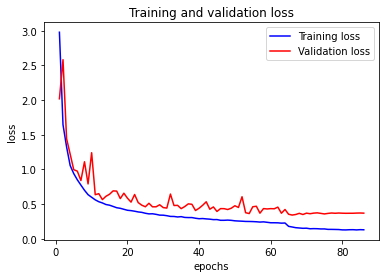

In [23]:
draw_graphics(fit_history, 'loss')

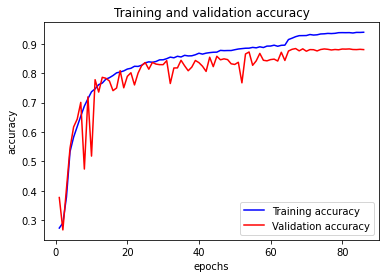

In [24]:
draw_graphics(fit_history, 'accuracy')

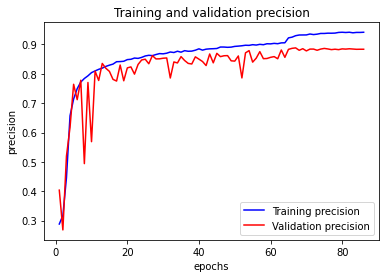

In [25]:
draw_graphics(fit_history, 'precision')

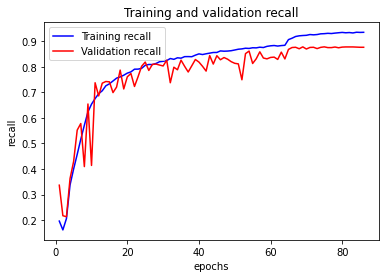

In [26]:
draw_graphics(fit_history, 'recall')

In [27]:
x_test = []
y_test = []

for image_name, emotion in test_df.values:
    image = tf.keras.preprocessing.image.load_img(
        os.path.join(test_dir, image_name),
        target_size=target_size,
        interpolation=interpolation,
        color_mode=color_mode,
    )
    
    x_test.append(tf.keras.preprocessing.image.img_to_array(image))
    y_test.append(labels.index(emotion))
        
x_test = np.array(x_test)
y_test = np.array(y_test)

In [28]:
def draw_confusion_matrix(y_true, y_pred, labels):
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    display = ConfusionMatrixDisplay(cm, display_labels=labels)

    _, ax = plt.subplots(figsize=(10, 10))
    display.plot(cmap=plt.cm.Blues, ax=ax)
    plt.show()

In [29]:
def compute_metrics(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 score: {2 * (precision * recall) / (precision + recall) * 100:.2f}%')

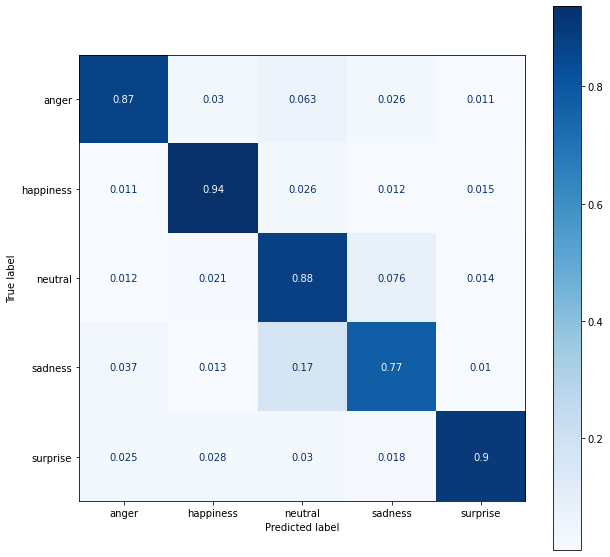

Accuracy: 88.34%
Precision: 86.29%
Recall: 87.08%
F1 score: 86.68%


In [30]:
# best
min_loss_model = tf.keras.models.load_model(f'../models/{notebook_name}/min_loss.h5')
y_pred = min_loss_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)

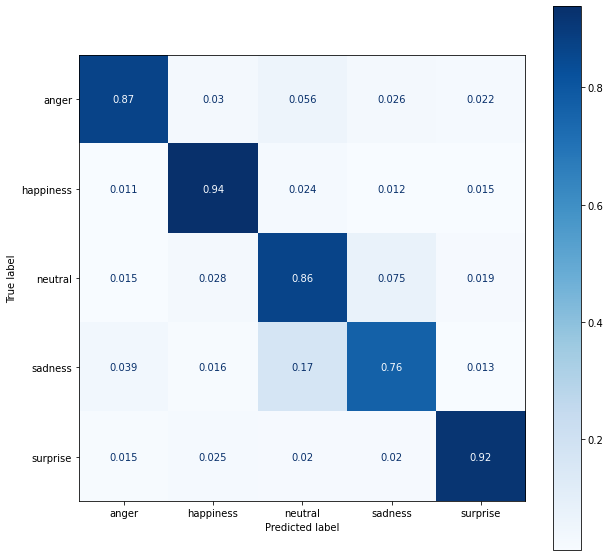

Accuracy: 88.01%
Precision: 85.75%
Recall: 86.97%
F1 score: 86.36%


In [31]:
max_accuracy_model = tf.keras.models.load_model(f'../models/{notebook_name}/max_accuracy.h5')
y_pred = max_accuracy_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)

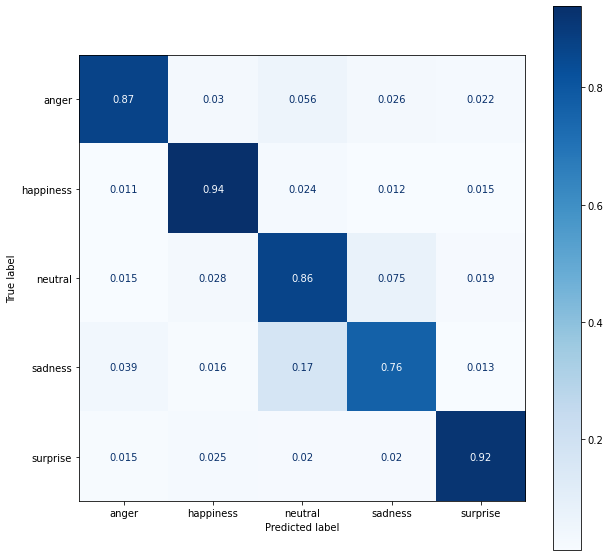

Accuracy: 88.01%
Precision: 85.75%
Recall: 86.97%
F1 score: 86.36%


In [32]:
max_precision_model = tf.keras.models.load_model(f'../models/{notebook_name}/max_precision.h5')
y_pred = max_precision_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)

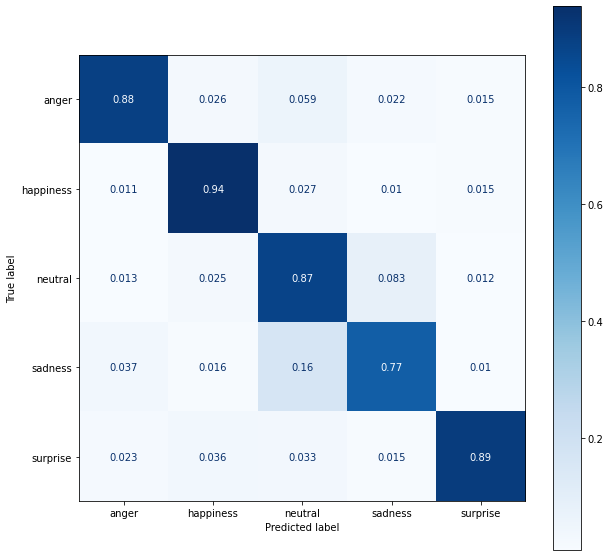

Accuracy: 88.01%
Precision: 86.04%
Recall: 86.94%
F1 score: 86.49%


In [33]:
max_recall_model = tf.keras.models.load_model(f'../models/{notebook_name}/max_recall.h5')
y_pred = max_recall_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)